##### Questoin > Supervisor > LLM Or RAG 

In [140]:
pip install langchain_groq sentence_transformers faiss-cpu pydantic python-dotenv pypdf bs4 langchain langchain_core langchain-community langchain_huggingface langchain_google_genai langchain-pinecone langgraph langchain-openai langchain_groq langchain_google_genai google-generativeai  pymupdf wikipedia arxiv defusedxml  youtube_search langchain-tavily langgraph chromadb langchain[chromadb]


zsh:1: no matches found: langchain[chromadb]


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [141]:
#### import
import os
from dotenv import load_dotenv
from langgraph.graph import Graph
from IPython.display import Image, display
load_dotenv()


True

In [142]:
#from langchain_google_genai import ChatGoogleGenerativeAI
#model=ChatGoogleGenerativeAI(model='models/gemini-1.5-flash')
from langchain_groq import ChatGroq
model= ChatGroq(model="deepseek-r1-distill-llama-70b")
output=model.invoke('Great Day !! ')
print(output.content)

<think>

</think>

Great day to you as well! How can I assist you today? 😊


#### Configure the embdeeing Model

In [143]:
from langchain_huggingface import HuggingFaceEmbeddings
embeddings = HuggingFaceEmbeddings(model_name="BAAI/bge-small-en")
len(embeddings.embed_query("Hi"))

384

##### Lets take a Data embedd it and store in Vector Database

In [144]:
##### Imports
from langchain_community.document_loaders import TextLoader, DirectoryLoader
from langchain_community.vectorstores import Chroma
from langchain.text_splitter import RecursiveCharacterTextSplitter
import operator
from langchain_core.tools import tool
from typing import List
from pydantic import BaseModel , Field
from langchain.prompts import PromptTemplate
from typing import TypedDict, Annotated, Sequence
from langchain_core.messages import BaseMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph import StateGraph,END,MessagesState,START
from langgraph.prebuilt import ToolNode


In [145]:
def call_model(state: MessagesState):
    message = state['messages'][-1]
    if isinstance(message, HumanMessage):
        question_text = message.content
    else:
        question_text = str(message)
    question = HumanMessage(content=question_text)
    print(f"this is your question message: {question}")
    response = model.invoke([question])
    
    return {"messages": [response.content]}

In [146]:
state = {"messages": ["how are you doing today !! "]}

In [147]:
call_model(state)

this is your question message: content='how are you doing today !! ' additional_kwargs={} response_metadata={}


{'messages': ["<think>\nAlright, someone just asked me how I'm doing today. I need to respond in a friendly and helpful way.\n\nI should acknowledge their greeting and express that I'm here to help them.\n\nMaybe I can offer assistance by asking how I can assist them today.\n\nKeeping it positive and open-ended would be best.\n</think>\n\nI'm just a computer program, so I don't have feelings, but thanks for asking! How can I assist you today?"]}

In [148]:
workflow=StateGraph(MessagesState)
workflow.add_node("mybot",call_model)

In [149]:
app = workflow.compile()

ValueError: Graph must have an entrypoint: add at least one edge from START to another node

##### This is the workflow with tool calling 
##### Binding the tool to the LLM / 
##### Note: Model Use some good model for agentic workflow , as opensource model might not give the correct output
##### Testing a llm_with_tool 


In [ ]:
@tool
def search(query:str):
    """this is my custom tool for earching a weather"""
    if "delhi" in query.lower():
        return "the temperature is 45 degree and sunny "
    else:
        return "the temp is 25 degree and cloudy"

In [ ]:
search.invoke("what is the temperate in Hyderabad")
tools = [search]
llm_with_tool = model.bind_tools(tools)
response = llm_with_tool.invoke("what is the weather in delhi")
print(response)
response.tool_calls

content='' additional_kwargs={'tool_calls': [{'id': 'wwsj697vb', 'function': {'arguments': '{"query":"weather in Delhi"}', 'name': 'search'}, 'type': 'function'}]} response_metadata={'token_usage': {'completion_tokens': 149, 'prompt_tokens': 133, 'total_tokens': 282, 'completion_time': 0.620676604, 'prompt_time': 0.008572247, 'queue_time': 0.054663813, 'total_time': 0.629248851}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None} id='run--44e9c0ab-d697-4ddc-9e73-8a25dd373bac-0' tool_calls=[{'name': 'search', 'args': {'query': 'weather in Delhi'}, 'id': 'wwsj697vb', 'type': 'tool_call'}] usage_metadata={'input_tokens': 133, 'output_tokens': 149, 'total_tokens': 282}


[{'name': 'search',
  'args': {'query': 'weather in Delhi'},
  'id': 'wwsj697vb',
  'type': 'tool_call'}]

In [ ]:
def call_model(state:MessagesState):
    question = state["messages"]
    response = llm_with_tool.invoke(question)
    return {"messages": [response]}

In [ ]:
input = {"messages": ["what is a weather in delhi "]}
response = call_model(input)
response["messages"][-1].content
response["messages"][-1].tool_calls

[{'name': 'search',
  'args': {'query': 'weather in Delhi'},
  'id': '68qzrj7fh',
  'type': 'tool_call'}]

In [ ]:
##### what ever will come from call_modek router function will redirect to appropriate tool
def router_function(state:MessagesState):
    message = state["messages"]
    last_message = ["message"][-1]
    if last_message.tool_calls:
        return "tools"
    else:
        return END


In [ ]:
tools

[StructuredTool(name='search', description='this is my custom tool for earching a weather', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x34da398a0>)]

In [ ]:
tool_node=ToolNode(tools)

#### Define workflow

In [153]:
workflow2 = StateGraph(MessagesState)

In [154]:
workflow2.add_node("llm_with_tool", call_model)
workflow2.add_node("mytools", tool_node)

In [155]:
workflow2.add_edge(START, "llm_with_tool")
workflow2.add_conditional_edges("llm_with_tool", router_function, {"tools": "mytools", END:END})

In [156]:
app2=workflow2.compile()

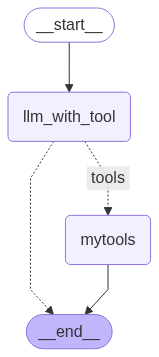

In [157]:
from IPython.display import Image, display
display(Image(app2.get_graph().draw_mermaid_png()))

##### Testing the App

In [ ]:
app2.invoke({"messages":["what is a weather in bengraluru?"]})

AttributeError: 'str' object has no attribute 'tool_calls'

In [158]:
app2.invoke({"messages":["what is a weather in delhi?"]})

this is your question message: content='what is a weather in delhi?' additional_kwargs={} response_metadata={}


AttributeError: 'str' object has no attribute 'tool_calls'

In [159]:
app2.invoke({"messages":["hi how are you?"]})

this is your question message: content='hi how are you?' additional_kwargs={} response_metadata={}


AttributeError: 'str' object has no attribute 'tool_calls'

In [160]:
##### Final Answer 
response["messages"][-1].content

TypeError: 'AIMessage' object is not subscriptable

In [161]:
#### 
app3=workflow2.compile()
workflow2.add_edge("mytools", llm_with_tool)

Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.


TypeError: unhashable type: 'RunnableBinding'

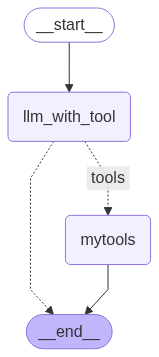

In [162]:
from IPython.display import Image, display
display(Image(app3.get_graph().draw_mermaid_png()))

In [ ]:
#### Calling steam you will get response from each tool
for output in app3.stream({"mesages": []"what is the weather in new delhi "]}):
    for key, value in output.item():
        print(f"here is the output {key}")
        print(value)


In [164]:
#### # Memory class in langchain
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()